In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd /notebooks/

/notebooks


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from tqdm.notebook import trange, tqdm
from digital_twin_library import SubsetSampler, corr
import seaborn as sns
from neuralpredictors.data.datasets import FileTreeDataset
from neuralpredictors.measures.modules import PoissonLoss
from torch.utils.data import DataLoader
from digital_twin_library import *
from torch.optim.lr_scheduler import ReduceLROnPlateau

from neuralpredictors.data.transforms import (
    ToTensor,
    NeuroNormalizer,
    ScaleInputs,
)
from neuralpredictors.data.samplers import RepeatsBatchSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Configure the dataset, samplers and loaders

In [4]:
root_dir = 'data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6'
dat = FileTreeDataset(root_dir, 'images', 'responses')

transforms = [ScaleInputs(scale=0.25), ToTensor(torch.cuda.is_available())]
transforms.insert(0, NeuroNormalizer(dat))
dat.transforms.extend(transforms)

train_sampler = SubsetSampler(dat.trial_info.tiers == 'train', shuffle=True)
test_sampler = SubsetSampler(dat.trial_info.tiers == 'test', shuffle=False)
val_sampler = SubsetSampler(dat.trial_info.tiers == 'validation', shuffle=False)

train_loader = DataLoader(dat, sampler=train_sampler, batch_size=64)
val_loader = DataLoader(dat, sampler=val_sampler, batch_size=64)
test_loader = DataLoader(dat, sampler=test_sampler, batch_size=64)

# Early stopping and learning rate scheduler

In [7]:
# Define the early stopping criteria
early_stopping_patience = 5
early_stopping_counter = 0
best_val_loss = float('-inf')

model = ConvModel(layers=3, input_kern=11, hidden_kern=5, hidden_channels=32, output_dim=8372)
model = model.to(device)
poisson_loss = PoissonLoss() # use different loss
gamma = 1e-4
loss_fn = lambda outputs, targets: poisson_loss(outputs, targets) + gamma * model.regularizer()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the learning rate schedule
lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Define the number of epochs
epochs = 100

for epoch in trange(epochs):
    # Training loop
    loss = train_epoch(model, train_loader, optimizer, loss_fn)
    
    # Validation loop
    with torch.no_grad():
        val_corrs = get_correlations(model, val_loader)
    validation_correlation = val_corrs.mean()
    
    # Update learning rate schedule
    lr_scheduler.step(validation_correlation)
    
    # Print training and validation losses
    print(f'Epoch [{epoch+1}/{epochs}], validation correlation: {validation_correlation:.4f}')
    
    # Check for early stopping
    if validation_correlation > best_val_loss:
        best_val_loss = validation_correlation
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print('Early stopping triggered!')
            break


Epoch [1/100], validation correlation: 0.0362
Epoch [2/100], validation correlation: 0.0555
Epoch [3/100], validation correlation: 0.0674
Epoch [4/100], validation correlation: 0.0820
Epoch [5/100], validation correlation: 0.0871
Epoch [6/100], validation correlation: 0.0891
Epoch [7/100], validation correlation: 0.0959
Epoch [8/100], validation correlation: 0.1056
Epoch [9/100], validation correlation: 0.1120
Epoch [10/100], validation correlation: 0.1125
Epoch [11/100], validation correlation: 0.1251
Epoch [12/100], validation correlation: 0.1228
Epoch [13/100], validation correlation: 0.1370
Epoch [14/100], validation correlation: 0.1434
Epoch [15/100], validation correlation: 0.1482
Epoch [16/100], validation correlation: 0.1563
Epoch [17/100], validation correlation: 0.1570
Epoch [18/100], validation correlation: 0.1656
Epoch [19/100], validation correlation: 0.1693
Epoch [20/100], validation correlation: 0.1761
Epoch [21/100], validation correlation: 0.1725
Epoch [22/100], valida

Plot the correlations

In [9]:
with torch.no_grad():
    train_corrs = get_correlations(model, train_loader)
    val_corrs = get_correlations(model, val_loader)


<AxesSubplot:ylabel='Count'>

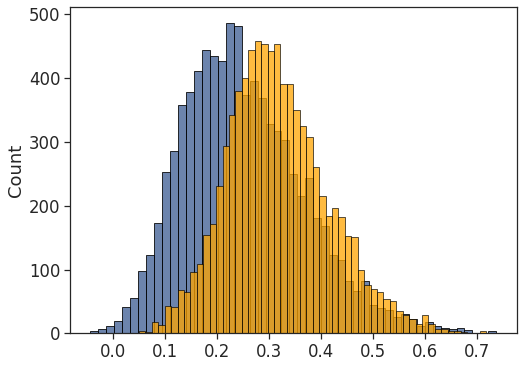

In [10]:
sns.set_context('notebook', font_scale=1.5)
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(val_corrs, kde=False, ax = ax, color=sns.xkcd_rgb['denim blue'], label='Validation')
sns.histplot(train_corrs, kde=False, ax = ax, color='orange', label='Train')

# Save the model

In [ ]:
torch.save(model.state_dict(), 'models/model.pt')
